In [9]:
import pandas as pd
import numpy as np
import nltk
import re           
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")


In [10]:
df = pd.read_csv('/kaggle/input/dattacnn/validation.csv')

In [11]:
df.drop_duplicates(['abstract'], inplace=True)
df = df.drop(['id'], axis= 1)
df.reset_index(inplace=True, drop=True)

In [13]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in df['article']:
    cleaned_text.append(text_cleaner(t))

In [14]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in df['abstract']:
    cleaned_summary.append(summary_cleaner(t))

df['article']=cleaned_text
df['abstract']=cleaned_summary
df['abstract'].replace('', np.nan, inplace=True)
df.dropna(axis=0,inplace=True)

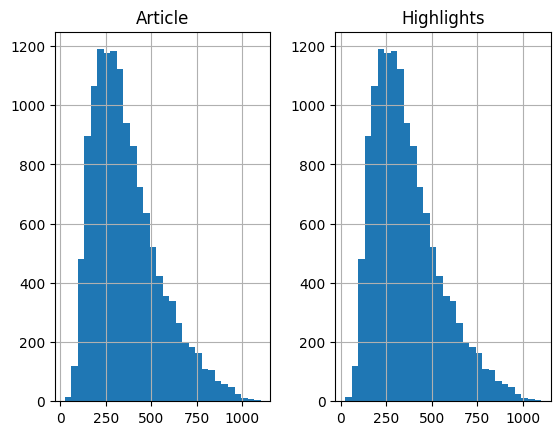

In [15]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['article']:
      text_word_count.append(len(i.split()))

for i in df['article']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'Article':text_word_count, 'Highlights':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [16]:
from sklearn.utils import shuffle
df_shuffled = shuffle(df, random_state=42)  # random_state for reproducibility
subset_size = int(0.1 * len(df_shuffled)) # take 0.25 of data length عايزين نخلص 
df = df_shuffled.iloc[:subset_size]
df

,article,abstract
1006,lucky recipient bunch fragrant roses valentine day likely came kenya country third largest exporter cut flowers world accounting around sales european union famed long lasting kenya roses carnatio...,kenya is one of the biggest flower exporters in the world around one in three flowers sold in europe come from the country
8607,house collapsed pile rubble builders started reconfigure inside property split two homes property rodney way romford collapsed tuesday leading london fire brigade evacuate surrounding residents fe...,the two bedroom end of terrace house collapsed on tuesday morning builders had demolished garage and stripped the inside of the house developers wanted to build second house on the side of the ori...
6945,erotic fiction made millions seems james author fifty shades grey trilogy new passion life year old spotted driving tesla model electric car shopping trip john lewis miss james whose real name eri...,fifty shades author james was spotted in her new electric car she swapped her mini for the battery powered luxury tesla model sedan boasts top speed of mph and can do to in seconds former tv execu...
11788,manchester city chelsea set challenge manchester united services gareth bale summer pressure bale madrid intensified recent weeks move back premier league cards assumed bale leave madrid move unit...,gareth bale suitors now include chelsea and manchester city chelsea may put price tag on petr cech west ham want sensational reunion with carlos tevez liverpool are convinced there is no interest ...
12763,thorgan hazard revealed remains ambition return chelsea despite leaving club permanent basis february year old younger brother eden joined borussia monchengladbach loan last summer made deal bunde...,thorgan hazard joined borussia monchengladbach on loan last summer the year old made the switch permanent at the end of february chelsea retained buy back option as part of thetransfer hazard reve...
...,...,...
8719,georgia police officer shot dead reportedly drunk gunman ambushed cops heavy fog early wednesday family members identified slain fulton county officer year old terence avery green department years...,family members identified the slain fulton county officer as terence avery green who had been with the department for years he had headed to street near fairburn with other officers following call...
14,self driving car gearing mile cross country road trip san francisco new york begins next week person always behind wheel autonomous car developed delphi automotive order take control situation veh...,the delphi automotive car will drive eight hours day for eight days there will be driver behind the wheel in case there is situation car cannot handle on its own delphi said trip will be ultimate ...
8430,number seven steven gerrard side walked onto hallowed anfield turf roar heard sides stadium fans welcomed return brilliant exciting unpredictable maverick luis suarez liverpool fan favourite got t...,luis suarez came off the bench to huge roar at anfield on his return the uruguayan played for steven gerrard team in the all star game suarez praised gerrard as the greatest one and posted photo o...
4099,today might mother day comes staying slim women afford put feet according study burn far fewer calories watching sofa partners doctors measured much energy three couples expended day day activitie...,doctors measured how much energy three couples expended day to day dr chris van tulleken said women burned less because they weighed less results shown in bbc programme the truth about calories on...


In [17]:
# Check for missing or null values in Article and Abstract fields
print("Missing Values in Abstract and Title fields:")
print(df[['article', 'abstract']].isnull().sum())

Missing Values in Abstract and Title fields:
article     0
abstract    0
dtype: int64


In [1]:
import os
import random

import numpy as np
import pandas as pd
import regex as re
import unicodedata
import contractions
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datasets import Dataset

import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import PegasusForConditionalGeneration, PegasusTokenizer, Trainer, TrainingArguments
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction, corpus_bleu
from rouge import Rouge
from rouge_score import rouge_scorer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model


# Download WordNet for NLTK
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [29]:
# Remove duplicates if necessary
df = df.drop_duplicates(subset=['article', 'abstract'])  # Remove based on Abstract-Title pairs

In [35]:
def evaluate_model(common_model_name, actual_model_name, df, batch_size=5):
    # Create a smoothing function
    smoothing_function = SmoothingFunction()

    # Load the model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(actual_model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(actual_model_name)

    # Filter for abstracts in the 250-300 word category
    filtered_df = df[df['abstract_word_category'] == '200-250']
    
    # Adjust sample size if filtered_df has fewer than 500 rows
    sample_size = min(500, len(filtered_df))  
    sampled_rows = filtered_df.sample(n=sample_size, random_state=42)

    # Initialize cumulative scores
    total_bleu = 0
    total_rouge_1 = 0
    total_rouge_2 = 0
    total_rouge_l = 0
    num_summaries = 0
    rouge = Rouge()

    for i in tqdm(range(0, len(sampled_rows), batch_size)):
        texts = sampled_rows["article"].iloc[i:i + batch_size].tolist()
        actual_summaries = sampled_rows["abstract"].iloc[i:i + batch_size].tolist()

        inputs = tokenizer(texts, return_tensors="pt", max_length=512, truncation=True, padding=True)

        with torch.amp.autocast(device_type='cpu'):
            summary_ids = model.generate(inputs['input_ids'], max_length=275, min_length=175, length_penalty=1.0, num_beams=2, early_stopping=True)

        summaries = [tokenizer.decode(sid, skip_special_tokens=True) for sid in summary_ids]

        for actual_summary, summary in zip(actual_summaries, summaries):
            reference = [actual_summary.split()]
            candidate = summary.split()
            bleu_score = sentence_bleu(reference, candidate, smoothing_function=smoothing_function.method1)

            scores = rouge.get_scores(summary, actual_summary)[0]
            
            # Accumulate scores
            total_bleu += bleu_score
            total_rouge_1 += scores['rouge-1']['f']
            total_rouge_2 += scores['rouge-2']['f']
            total_rouge_l += scores['rouge-l']['f']
            num_summaries += 1

    # Calculate final scores
    final_bleu = total_bleu / num_summaries
    final_rouge_1 = total_rouge_1 / num_summaries
    final_rouge_2 = total_rouge_2 / num_summaries
    final_rouge_l = total_rouge_l / num_summaries

    # Create a Series to hold the final scores
    scores_series = pd.Series({
        'Model': common_model_name,
        'Final BLEU Score': final_bleu,
        'Final ROUGE-1': final_rouge_1,
        'Final ROUGE-2': final_rouge_2,
        'Final ROUGE-L': final_rouge_l,
    })

    return scores_series


In [36]:
# Initialize an empty DataFrame
results_df = pd.DataFrame()  

# Call the function for different models
common_model_names = ["Pegasus","BartCNN","CNN"]
actual_model_names = [ 
    "google/pegasus-large",
    "facebook/bart-large-cnn",
    "facebook/bart-large"
]

for common_name, actual_name in zip(common_model_names, actual_model_names):
    scores = evaluate_model(common_name, actual_name, df)
    
    # Convert scores to DataFrame if it's not already
    scores_df = pd.DataFrame([scores])  # Assuming scores is a dict
    results_df = pd.concat([results_df, scores_df], ignore_index=True)

results_df

tokenizer_config.json:   0%|          | 0.00/1.99k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/6.60M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.77k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.49k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/257 [00:00<?, ?B/s]

100%|██████████| 1/1 [00:50<00:00, 50.84s/it]


tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.09k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

100%|██████████| 1/1 [01:07<00:00, 67.16s/it]


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

100%|██████████| 1/1 [00:54<00:00, 54.46s/it]


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

100%|██████████| 1/1 [01:17<00:00, 77.01s/it]


,Model,Final BLEU Score,Final ROUGE-1,Final ROUGE-2,Final ROUGE-L
0,Fine Tuned Pegasus,0.013764,0.187067,0.040512,0.173048
1,Pegasus,0.058678,0.326255,0.111350,0.302142
2,BartCNN,0.063247,0.349006,0.138280,0.331866
3,CNN,0.079905,0.299293,0.110637,0.264445
